<a href="https://colab.research.google.com/github/leonardoLavagna/Iscas2026/blob/main/notebooks/iscas_2026_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ISCAS 2026
**Notebook 2**

A unified framework Grover-quantum walks for NISQ attacks agains symmetric encryption-decryption schemes: simplified AES version.

## Setup

In [ ]:
!git clone https://github.com/leonardoLavagna/Iscas2026

In [2]:
import os
os.chdir("Iscas2026")

In [ ]:
!pip install -r requirements.txt

## Classical frequency attack

Here we discuss the frequency-based attack since, known the key and having access to an oracle with the power of inverting the S-Box in a single step the number of queries to this oracle are $O(1)$ (well, they are, in fact, just one).

In [26]:
from utilities.frequency_attack_aes import decrypt_sbox_xor, run_attack_trials, plot_success_curve
from utilities.simplified_aes import encrypt_sbox_xor

In [28]:
PT = "THEQUICKBROWNFOXJUMPSOVERTHELAZYDOG"
secret_k = 0x3A
CT = encrypt_sbox_xor(PT, secret_k)
CT

b'\x9f@\xd2\x7f\xa8\x8f\xb6\xa3\xbcE\x9d<\x92\x10\x9d\xaaQ\xa8\xf5\x02\xf9\x9dP\xd2E\x9f@\xd28!\xd0\xfb\xf3\x9d\xff'

In [29]:
results, steps = run_attack_trials(PT, secret_k, n_trials=1000, threshold=0.5)
print("Steps to reach success:", steps)

Steps to reach success: None


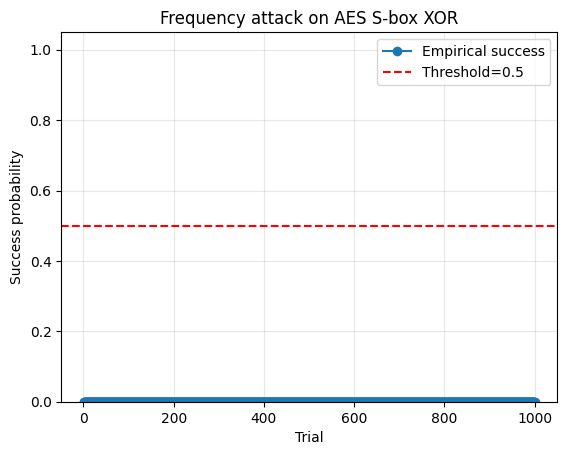

In [30]:
plot_success_curve(results, threshold=0.5)

Even this simplified version is secure and we assume it takes an exponential number of steps to reach a high enough probability of success.

## Quantum fault-tolerant attack

In the unified Grover-walk fault tolerant attack we have success with $O(\sqrt{N})\approx 16$ queries without having access to the S-box, but just the key. Precomputing $S$ in the Grover's oracle requires non trivial encodings and specialized algorithms which are not the scope of this analysis.

In [31]:
from utilities.grover_walk import coined_grover_walk_search
from qiskit import transpile
from qiskit.result import marginal_counts
from config import *

In [36]:
import matplotlib.pyplot as plt

In [32]:
def grover_walk_recover_key(true_k, shots=shots, backend=ideal_backend, steps=None):
    marked_bits = format(true_k, "08b")
    qc = coined_grover_walk_search(n=8, marked_state=marked_bits, steps=steps)
    tqc = transpile(qc, backend, optimization_level=3)
    result = backend.run(tqc, shots=shots).result()
    pos_counts = marginal_counts(result, indices=list(range(8,16))).get_counts()
    best_bits = max(pos_counts, key=pos_counts.get)
    return int(best_bits, 2)

In [34]:
def grover_success_vs_steps(secret_k, CT, steps_range=range(1,20), shots=shots, backend=ideal_backend):
    """
    Sweep Grover-walk steps and compute success probability
    of recovering the marked key.
    """
    marked_bits = format(secret_k, "08b")
    probs = []
    for s in steps_range:
        qc = coined_grover_walk_search(n=8, marked_state=marked_bits, steps=s)
        tqc = transpile(qc, backend, optimization_level=3)
        result = backend.run(tqc, shots=shots).result()
        pos_counts = marginal_counts(result, indices=list(range(8,16))).get_counts()
        succ = pos_counts.get(marked_bits, 0) / shots
        probs.append(succ)
    return list(steps_range), probs


In [33]:
k_grover = grover_walk_recover_key(secret_k)
print("Grover recovered key:", hex(k_grover))
print("Plaintext:", decrypt_sbox_xor(CT, k_grover))


Grover recovered key: 0x3a
Plaintext: THEQUICKBROWNFOXJUMPSOVERTHELAZYDOG


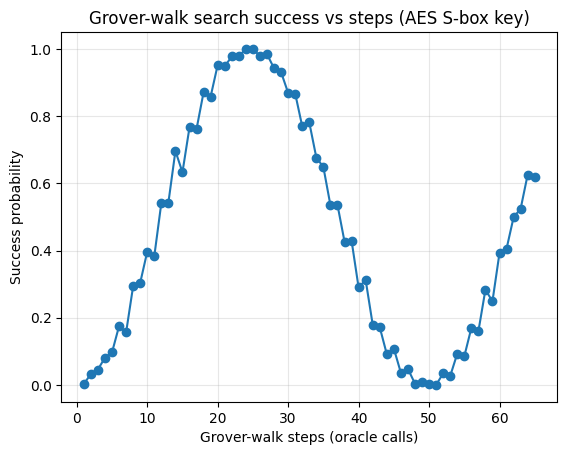

In [39]:
# Note: it can take a few minutes to run this cell
steps, probs = grover_success_vs_steps(secret_k, CT, steps_range=range(1,66))
plt.figure()
plt.plot(steps, probs, marker='o')
plt.xlabel("Grover-walk steps (oracle calls)")
plt.ylabel("Success probability")
plt.title("Grover-walk search success vs steps (AES S-box key)")
plt.grid(alpha=0.3)
plt.show()

This is the usual periodic results of the Grover's algorithm

## NISQ attack

In [ ]:
# Note: it can take a few minutes to run this cell
k_grover = grover_walk_recover_key(secret_k, backend=noisy_backend)
print("Grover recovered key:", hex(k_grover))
print("Plaintext:", decrypt_sbox_xor(CT, k_grover))

In [ ]:
# Note: it can take a few minutes to run this cell
steps_n, probs = grover_success_vs_steps(secret_k, CT, steps_range=range(1,12),
                                         backend=noisy_backend)
steps, probs = grover_success_vs_steps(secret_k, CT, steps_range=range(1,12))
plt.figure()
plt.plot(steps, probs, marker='o', label='Ideal')
plt.plot(steps_n, probs, marker='o', label='FakeVigoV2 noise')
plt.xlabel("Grover-walk steps (oracle calls)")
plt.ylabel("Success probability")
plt.title("Grover-walk search success vs steps (AES S-box key)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()